In [1]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [47]:
# Load datasets
train = pd.read_csv(r'/content/train.csv',parse_dates=['date'])
test = pd.read_csv(r'/content/test.csv', parse_dates=['date'])
stores = pd.read_csv(r'/content/stores.csv')
oil = pd.read_csv(r'/content/oil.csv', parse_dates=['date'])
holidays = pd.read_csv(r'/content/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv(r'/content/transactions.csv', parse_dates=['date'])

In [3]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [4]:
dataset=[train,test,stores,oil,holidays,transactions]
for data in dataset:
    print('Data-Types',data.dtypes)
    print('Missing value',data.isnull().sum())
    print('Info',data.info())

Data-Types id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object
Missing value id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
Info None
Data-Types id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
onpromotion             int64
dtype: object
Missing value id      

In [5]:
# Drop duplicates
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)
stores.drop_duplicates(inplace=True)
oil.drop_duplicates(inplace=True)
holidays.drop_duplicates(inplace=True)
transactions.drop_duplicates(inplace=True)

In [6]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [7]:
# Handle missing values in oil prices
oil['dcoilwtico'].interpolate(inplace=True)

In [8]:
# Handle missing values in other datasets
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
stores.fillna(method='ffill', inplace=True)
oil.fillna(method='ffill', inplace=True)
holidays.fillna(method='ffill', inplace=True)
transactions.fillna(method='ffill', inplace=True)

In [9]:
# Merge datasets
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays, on='date', how='left')

test = test.merge(stores, on='store_nbr', how='left')
test = test.merge(oil, on='date', how='left')
test = test.merge(holidays, on='date', how='left')

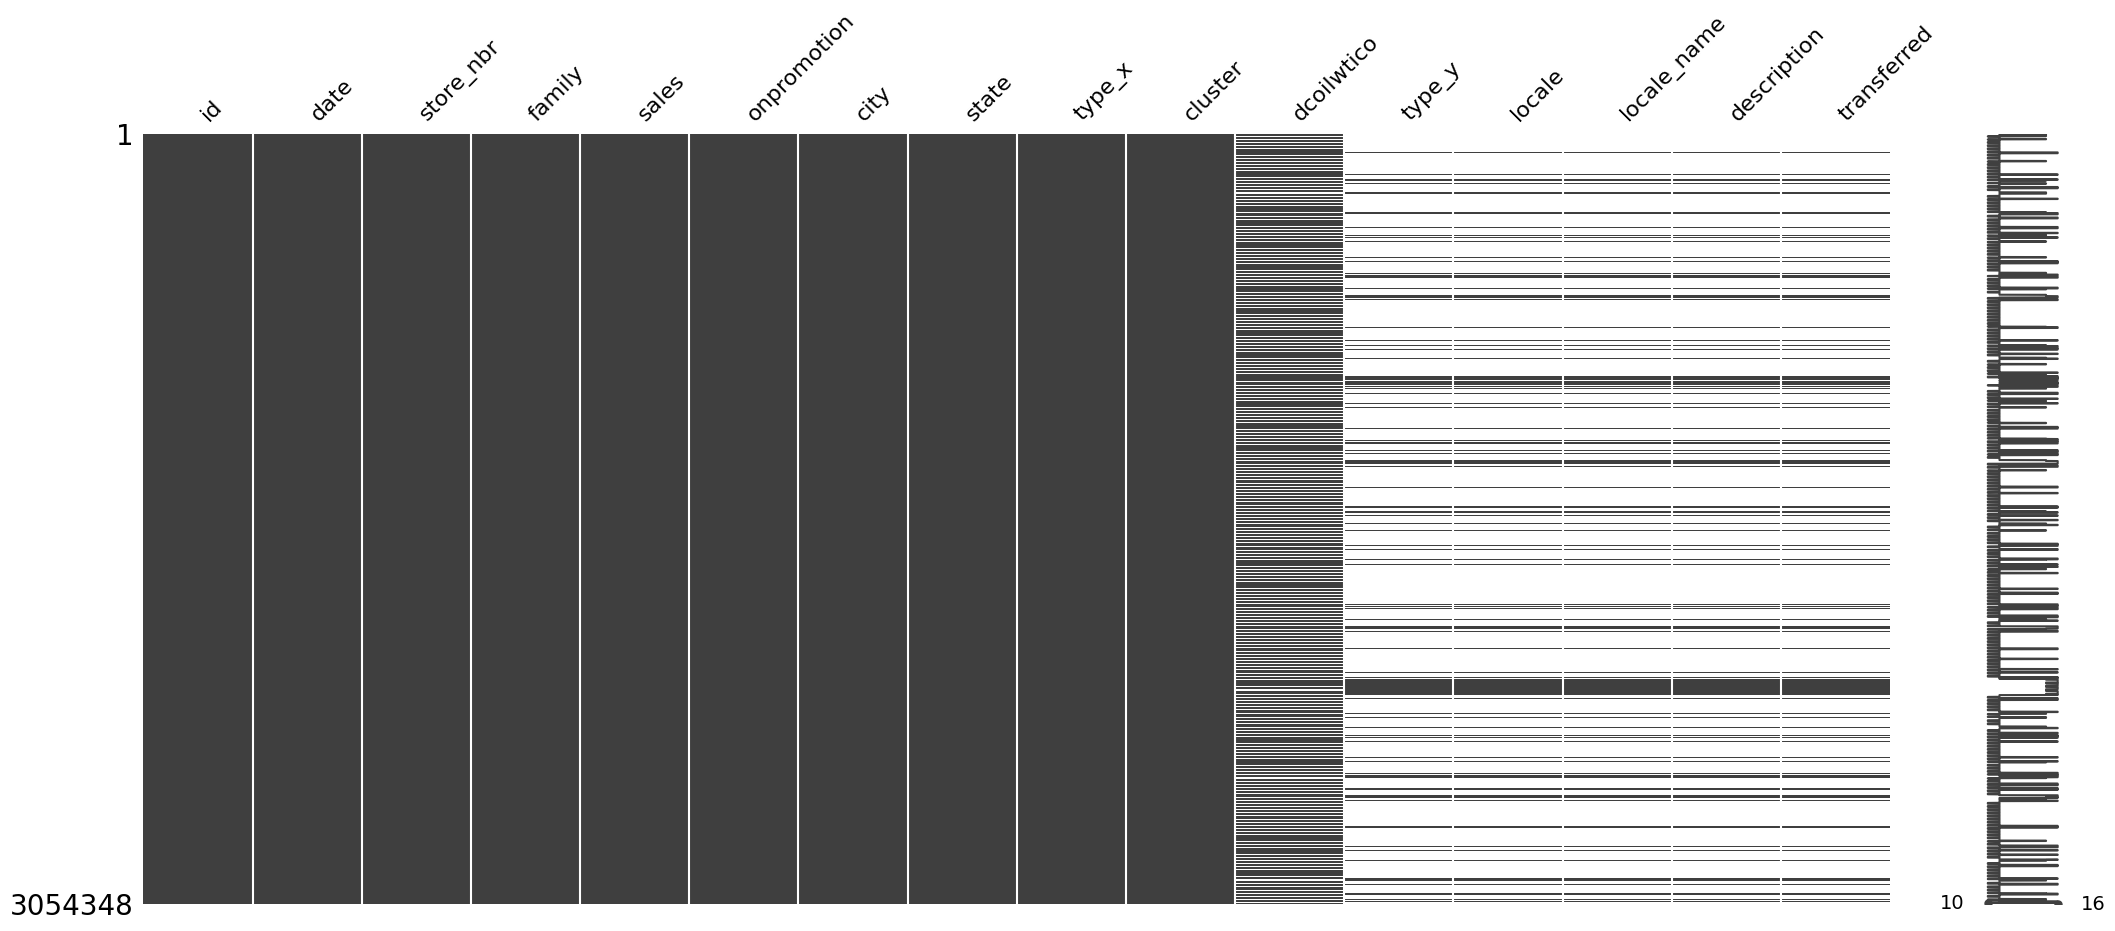

In [10]:
# Missing values visualization
msno.matrix(train)
plt.show()


In [11]:
# Check for duplicates
print("Duplicate Rows in Train Data:", train.duplicated().sum())


Duplicate Rows in Train Data: 0


In [12]:
# Summary statistics
print(train.describe())

                 id                           date     store_nbr  \
count  3.054348e+06                        3054348  3.054348e+06   
mean   1.504277e+06  2015-04-26 12:11:45.717619200  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.546768e+05            2014-03-01 00:00:00  1.400000e+01   
50%    1.507572e+06            2015-04-28 12:00:00  2.750000e+01   
75%    2.255120e+06            2016-06-22 00:00:00  4.100000e+01   
max    3.000887e+06            2017-08-15 00:00:00  5.400000e+01   
std    8.662610e+05                            NaN  1.558579e+01   

              sales   onpromotion       cluster    dcoilwtico  
count  3.054348e+06  3.054348e+06  3.054348e+06  2.174040e+06  
mean   3.590209e+02  2.617480e+00  8.481481e+00  6.792207e+01  
min    0.000000e+00  0.000000e+00  1.000000e+00  2.619000e+01  
25%    0.000000e+00  0.000000e+00  4.000000e+00  4.644750e+01  
50%    1.100000e+01  0.000000e+00  8.500000e+00  5.339500e+01  
75%

In [13]:
# prompt: # Feature Engineering
# train['day'] = train['date'].dt.day
# train['week'] = train['date'].dt.isocalendar().week
# train['month'] = train['date'].dt.month
# train['year'] = train['date'].dt.year
# train['day_of_week'] = train['date'].dt.dayofweek
# train['is_payday'] = train['day'].isin([15, train['date'].dt.days_in_month]).astype(int)

# ... (Your existing code)

# Feature Engineering
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

# Add a feature indicating if it's a payday (15th or last day of the month)
train['is_payday'] = (train['day'] == 15) | (train['day'] == train['date'].dt.days_in_month)
train['is_payday'] = train['is_payday'].astype(int)

# You can add more features here, such as:
# - Holiday indicators (e.g., is_holiday, holiday_type)
# - Weekend/weekday indicators
# - Lagged sales features
# - Rolling mean/std of sales

# ... (Rest of your code)


In [14]:
# Rolling statistics
train['sales_lag_7'] = train['sales'].shift(7)
train['sales_lag_30'] = train['sales'].shift(30)
train['rolling_mean_7'] = train['sales'].rolling(window=7).mean()
train['rolling_std_7'] = train['sales'].rolling(window=7).std()

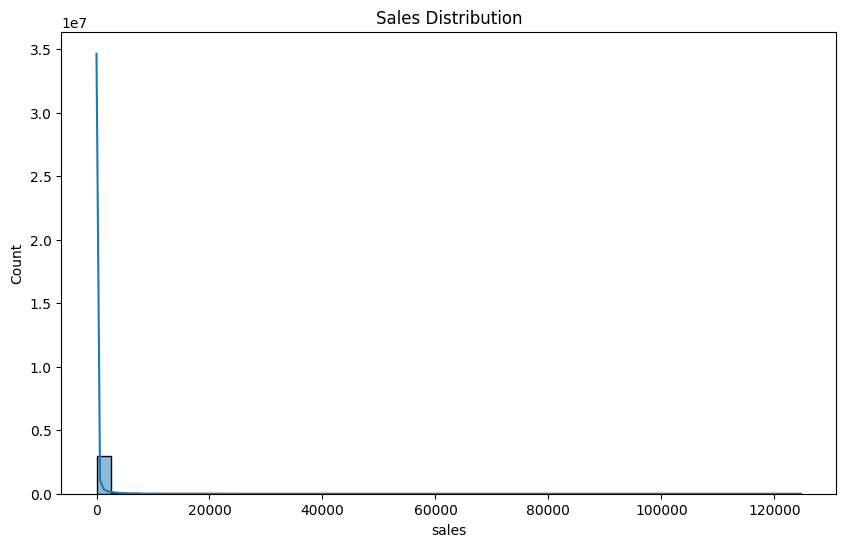

In [15]:
# Visualizing sales distribution
plt.figure(figsize=(10,6))
sns.histplot(train['sales'], bins=50, kde=True)
plt.title('Sales Distribution')
plt.show()


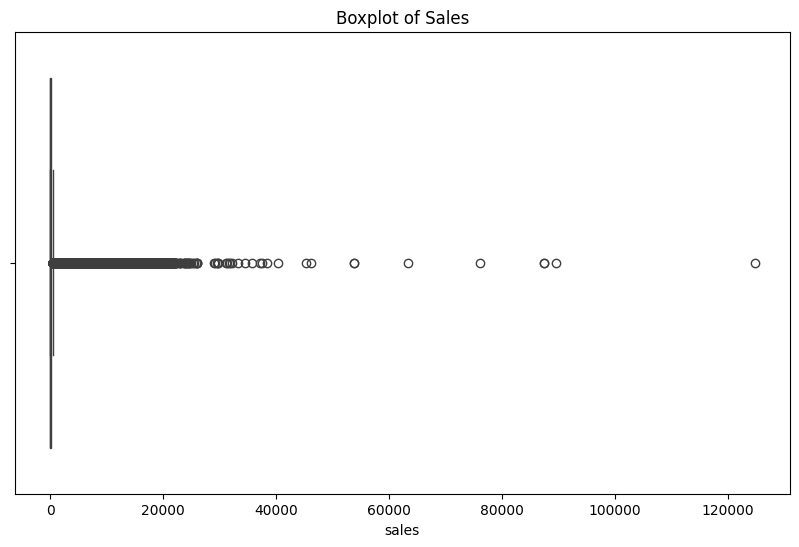

In [16]:

# Boxplot to detect outliers
plt.figure(figsize=(10,6))
sns.boxplot(x=train['sales'])
plt.title('Boxplot of Sales')
plt.show()

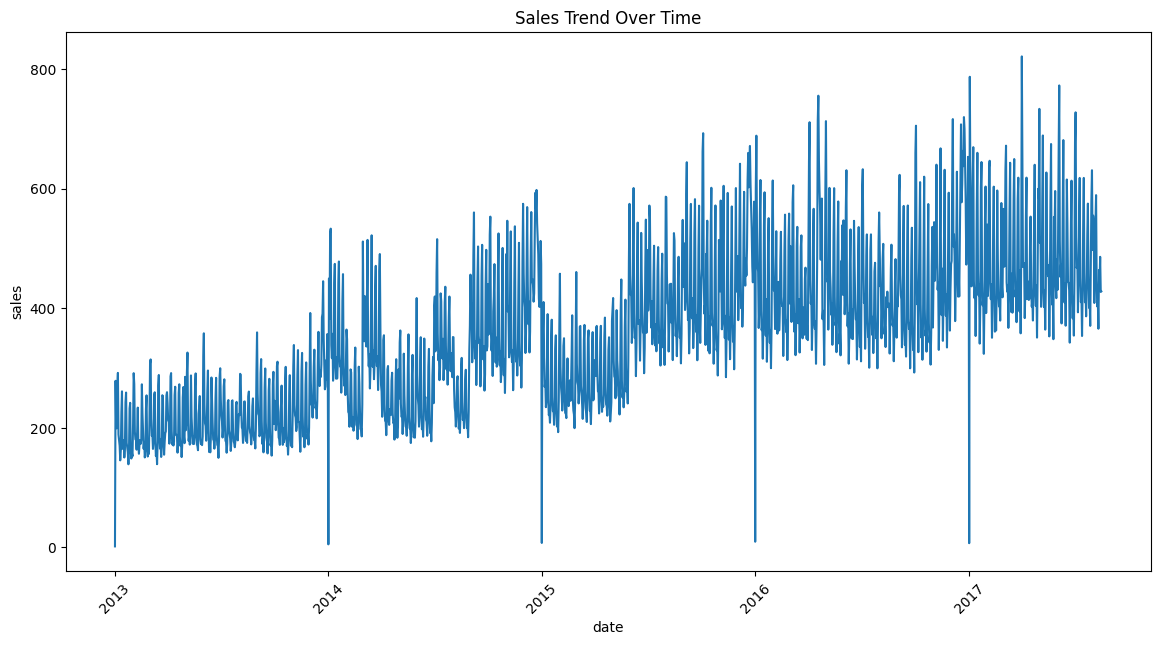

In [17]:
# Time series sales trend
plt.figure(figsize=(14,7))
sns.lineplot(data=train, x='date', y='sales', ci=None)
plt.title('Sales Trend Over Time')
plt.xticks(rotation=45)
plt.show()

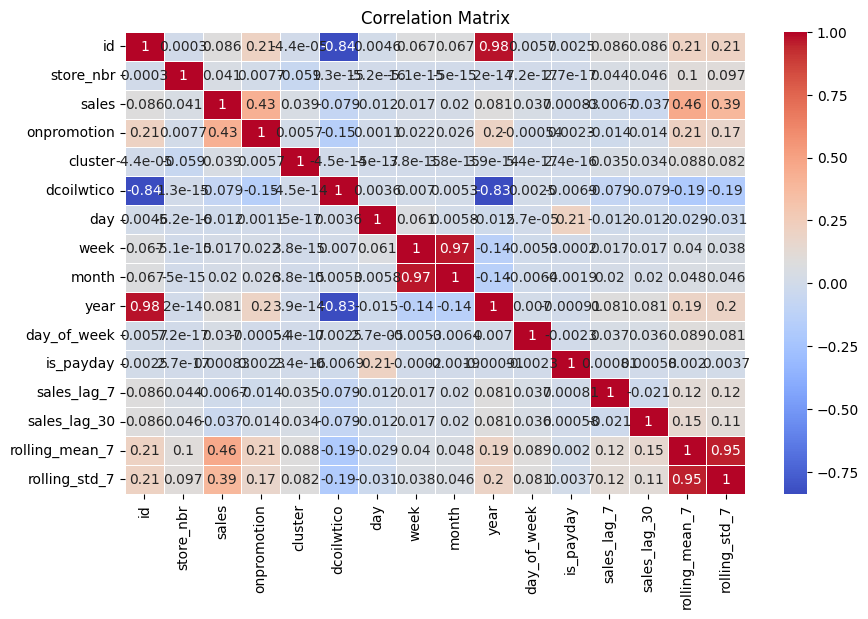

In [18]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

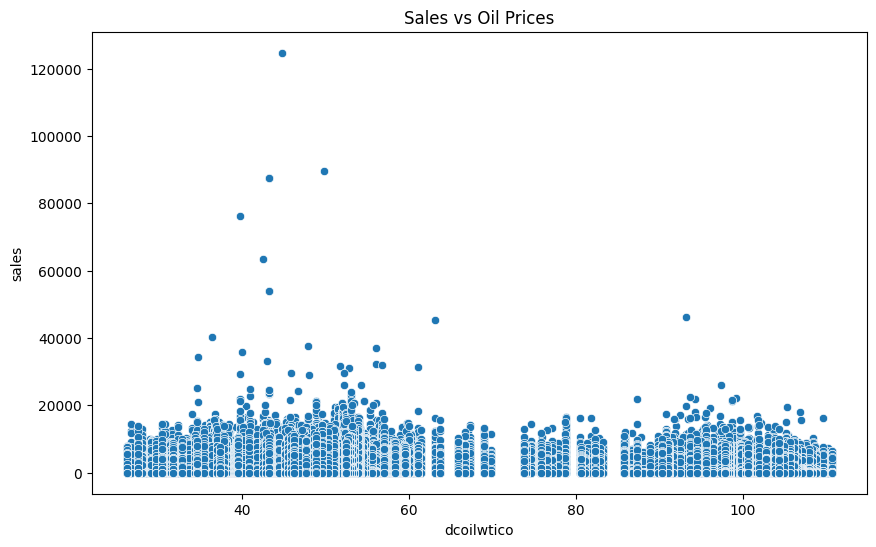

In [19]:

# Sales vs Oil Prices
plt.figure(figsize=(10,6))
sns.scatterplot(data=train, x='dcoilwtico', y='sales')
plt.title('Sales vs Oil Prices')
plt.show()

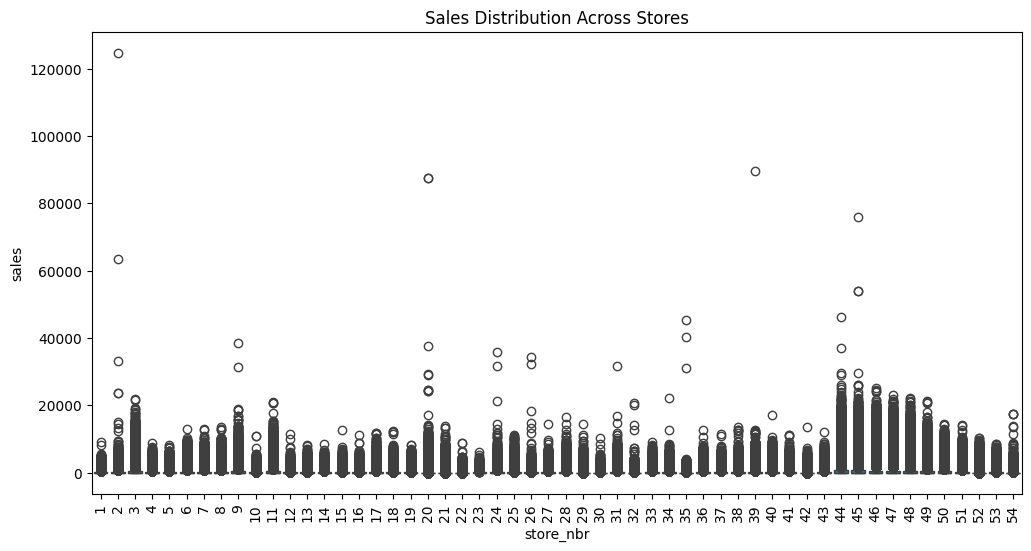

In [20]:
# Sales distribution across stores
plt.figure(figsize=(12,6))
sns.boxplot(x='store_nbr', y='sales', data=train)
plt.xticks(rotation=90)
plt.title('Sales Distribution Across Stores')
plt.show()


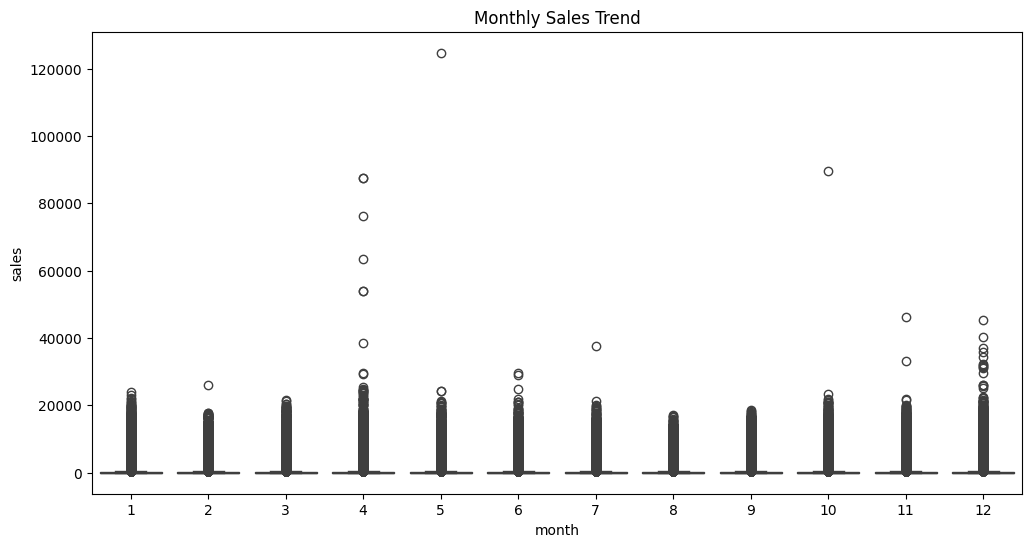

In [21]:
# Check seasonality trends
train['month'] = train['date'].dt.month
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='sales', data=train)
plt.title('Monthly Sales Trend')
plt.show()

In [22]:
numerical_data=train.select_dtypes(include=['float','int']).columns
categorical_data=train.select_dtypes(include=['category','object',bool]).columns

In [23]:
# Filling null values with mean using imputer
imputer_num=SimpleImputer(strategy='mean')
train[numerical_data]=imputer_num.fit_transform(train[numerical_data])

imputer_cat=SimpleImputer(strategy='most_frequent')
train[categorical_data]=imputer_cat.fit_transform(train[categorical_data])

In [24]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
type_x,0
cluster,0


In [25]:
train.dtypes

,0
id,float64
date,datetime64[ns]
store_nbr,float64
family,object
sales,float64
onpromotion,float64
city,object
state,object
type_x,object
cluster,float64


In [26]:
# Rolling Features
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).mean())
train.shape

(3054348, 27)

In [27]:
train.dropna(inplace=True)

In [28]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()

# Iterate through categorical columns
for col in train.select_dtypes(include=['category', 'object']).columns:
    train[col] = label.fit_transform(train[col])  # Use train[col], not col[col]
train

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,...,week,month,year,day_of_week,is_payday,sales_lag_7,sales_lag_30,rolling_mean_7,rolling_std_7,sales_rolling_mean_7
12474,12474.0,2013-01-08,1.0,0,2.000,0.0,18,12,3,13.0,...,2,1.0,2013.0,1.0,0.0,0.000,1008.00,69.503714,161.650943,2.428571
12475,12475.0,2013-01-08,1.0,1,0.000,0.0,18,12,3,13.0,...,2,1.0,2013.0,1.0,0.0,0.000,0.00,69.503714,161.650943,0.000000
12476,12476.0,2013-01-08,1.0,2,3.000,0.0,18,12,3,13.0,...,2,1.0,2013.0,1.0,0.0,0.000,637.00,7.777714,12.184220,1.714286
12477,12477.0,2013-01-08,1.0,3,1029.000,0.0,18,12,3,13.0,...,2,1.0,2013.0,1.0,0.0,0.000,0.00,150.349143,387.504866,959.571429
12478,12478.0,2013-01-08,1.0,4,0.000,0.0,18,12,3,13.0,...,2,1.0,2013.0,1.0,0.0,0.000,1439.00,150.349143,387.504866,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883.0,2017-08-15,9.0,28,438.133,0.0,18,12,1,6.0,...,33,8.0,2017.0,1.0,1.0,358.132,0.00,208.194429,246.188912,381.083426
3054344,3000884.0,2017-08-15,9.0,29,154.553,1.0,18,12,1,6.0,...,33,8.0,2017.0,1.0,1.0,112.954,23.33,226.702000,234.724439,121.605856
3054345,3000885.0,2017-08-15,9.0,30,2419.729,148.0,18,12,1,6.0,...,33,8.0,2017.0,1.0,1.0,2299.715,15.00,570.806143,843.065816,1525.855714
3054346,3000886.0,2017-08-15,9.0,31,121.000,8.0,18,12,1,6.0,...,33,8.0,2017.0,1.0,1.0,170.000,0.00,523.916429,859.914106,144.571429


In [29]:
# prompt: split the dataset into x and y

X = train.drop('sales', axis=1)
y = train['sales']


In [30]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [31]:
# Model Training
X_train = train.drop(columns=['date', 'sales'])
y_train = train['sales']

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
# Model Training and Evaluation
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

In [34]:
# Baseline Model (Naïve Forecasting)
y_pred_naive = train['sales'].shift(1).fillna(method='bfill')
rmse_naive, mape_naive, r2_naive = evaluate_model(train['sales'], y_pred_naive)

In [35]:
# # ARIMA Model
# from statsmodels.tsa.arima.model import ARIMA
# arima_model = ARIMA(train['sales'], order=(5,1,0))
# arima_fit = arima_model.fit()
# y_pred_arima = arima_fit.predict(start=1, end=len(train))
# rmse_arima, mape_arima, r2_arima = evaluate_model(train['sales'][1:], y_pred_arima[:-1])

In [36]:
# Random Forest Model
X = train[['month', 'day', 'day_of_week', 'year']]
y = train['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf, mape_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

In [38]:
# XGBoost Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb, mape_xgb, r2_xgb = evaluate_model(y_test, y_pred_xgb)

In [ ]:
# # LSTM Model
# X_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))
# model = Sequential([
#     LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
#     Dense(1)
# ])
# model.compile(optimizer='adam', loss='mse')
# model.fit(X_lstm, y_train, epochs=10, verbose=0)
# y_pred_lstm = model.predict(X_test_lstm).flatten()
# rmse_lstm, mape_lstm, r2_lstm = evaluate_model(y_test, y_pred_lstm)

In [39]:
rmse_xgb

np.float64(1092.3793556029502)

In [40]:

# Compare Model Performance
results = pd.DataFrame({
    'Model': ['Naïve', 'ARIMA', 'Random Forest', 'XGBoost', 'LSTM'],
    'RMSE': [rmse_naive, rmse_arima, rmse_rf, rmse_xgb, rmse_lstm],
    'MAPE': [mape_naive, mape_arima, mape_rf, mape_xgb, mape_lstm],
    'R-Squared': [r2_naive, r2_arima, r2_rf, r2_xgb, r2_lstm]
})
print(results)

           Model         RMSE          MAPE  R-Squared
0          Naïve  1565.073135  4.311695e+17  -0.993529
1  Random Forest  1092.499474  4.337934e+17   0.012790
2        XGBoost  1092.379356  4.338437e+17   0.013007


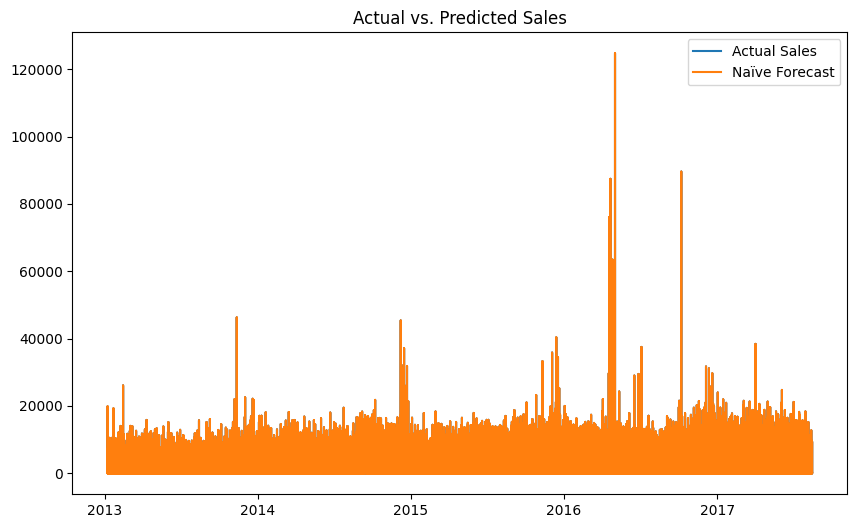

In [42]:
# Visualization
plt.figure(figsize=(10,6))
plt.plot(train['date'], train['sales'], label='Actual Sales')
plt.plot(train['date'], y_pred_naive, label='Naïve Forecast')
# plt.plot(train['date'][1:], y_pred_arima[:-1], label='ARIMA Forecast')
plt.legend()
plt.title('Actual vs. Predicted Sales')
plt.show()


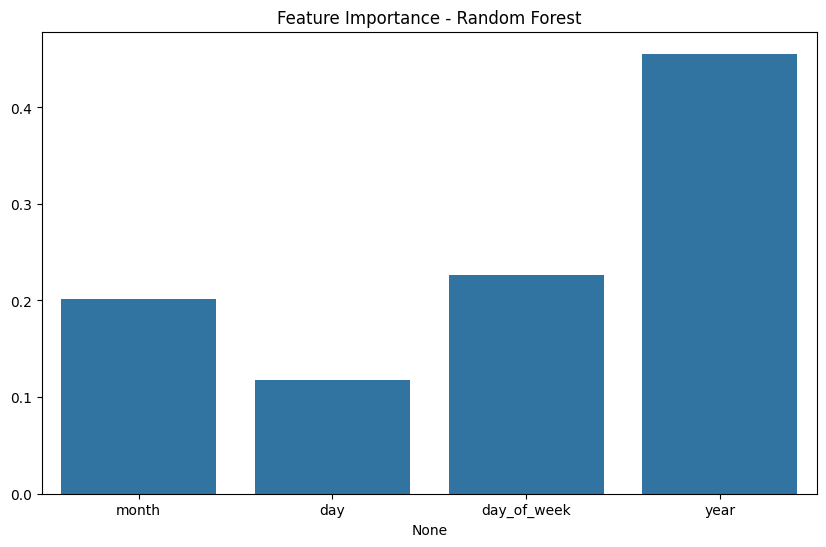

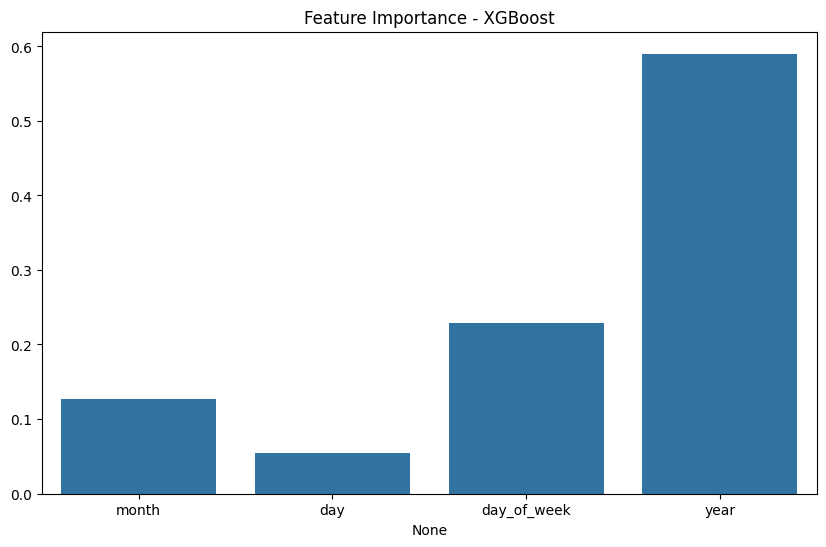

In [44]:
# Feature Importance for Random Forest and XGBoost
plt.figure(figsize=(10,6))
sns.barplot(x=X.columns, y=rf_model.feature_importances_)
plt.title('Feature Importance - Random Forest')
plt.show()
plt.figure(figsize=(10,6))
sns.barplot(x=X.columns, y=xgb_model.feature_importances_)
plt.title('Feature Importance - XGBoost')
plt.show()